<h1 align="center">ToxDataCommons to mwTab</h1> 

This Jupyter notebook demonstrates how to export data from [ToxDataCommons](fairtox.com) in order to deposit mass spectrometry data to the [Metabolomics Workbench](metabolomicsworkbench.org). 

__Created by: Rance Nault, Michigan State University__

-------

## Load packages
Import the mwtab python package. See https://github.com/MoseleyBioinformaticsLab/mwtab for installation instructions and documentation

In [163]:
import os
import sys
import csv
import gen3
import json
import mwtab
import warnings
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO
from datetime import datetime
from collections import OrderedDict
from expansion import Gen3Expansion # https://raw.githubusercontent.com/cgmeyer/gen3sdk-python/master/expansion/expansion.py

from gen3.auth import Gen3Auth
from gen3.index import Gen3Index
from gen3.query import Gen3Query

from gen3.submission import Gen3Submission

current_date = datetime.now().date()
formatted_date = current_date.strftime('%Y-%m-%d')

warnings.filterwarnings("ignore", category=UserWarning)

In [164]:
def process_node_data(node_name, data, key):
    node_df = pd.read_csv(StringIO(data), sep='\t', header=0)
    node_df[key] = node_df[key].str.split(',')
    node_df = node_df.explode(key)
    pattern = r'(^|\.)id($|\.)'
    drop_columns = [col for col in node_df.columns if pd.Series(col).str.contains(pattern).any()]
    node_df = node_df.drop(drop_columns, axis=1)
    node_df = node_df.reset_index(drop=True)
    return node_df

def get_unique_values(dataframe, column_name):
    unique_values = dataframe[column_name].unique()
    unique_string = ','.join(map(str, unique_values))
    return unique_string

def remove_newlines(obj):
    if isinstance(obj, dict):
        return {key: remove_newlines(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [remove_newlines(element) for element in obj]
    elif isinstance(obj, str):
        return obj.replace('\n', '').replace('\r', '')
    else:
        return obj

In [165]:
# Initiate instances of the Gen3 SDK Classes using credentials file for authentication.
# Change the directory path in "cred" to reflect the location of your credentials file.
api = "https://fairtox.com"
cred = "credentials.json"
auth = Gen3Auth(api, refresh_file=cred) # authentication class
sub = Gen3Submission(api, auth) # submission class
query = Gen3Query(auth) # query class
exp = Gen3Expansion(api,auth,sub) # class with some custom scripts
exp.get_project_ids()

Getting all project_ids you have access to in the data commons.
['MyFirstProgram-MyFirstProject']


['MyFirstProgram-MyFirstProject']

<h1 align="center">Obtain project data from <i>ToxDataCommons</i></h1> 

<h2 align="center">Study details</h2> 

In [166]:
studies_to_match = ['Prj171']

# STUDY NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='study', fileformat='tsv')
study_df = process_node_data('study', node_data, 'submitter_id')
study_df = study_df[study_df['submitter_id'].isin(studies_to_match)]

# CONTACT NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='contact', fileformat='tsv')
contact_df = process_node_data('contact', node_data, 'studies.submitter_id') 
study_df = pd.merge(study_df, contact_df, left_on='submitter_id', right_on='studies.submitter_id')

# FUNDING NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='funding', fileformat='tsv')
funding_df = process_node_data('funding', node_data, 'studies.submitter_id') 
study_df = pd.merge(study_df, funding_df, left_on='submitter_id_x', right_on='studies.submitter_id')

# PUBLICATION NODE
#publication = sub.export_node(program='MyFirstProgram',project='MyFirstProject',node_type='publication',fileformat='tsv')
#publication_df = pd.read_csv(StringIO(funding), sep='\t', header=0)
#study_df = pd.merge(study_df, publication_df, left_on='submitter_id_x', right_on='studies.submitter_id')

display(study_df)

,type_x,project_id_x,submitter_id_x,experimental_setting,organism,provenance_x,study_description,study_design,study_title,study_type,...,middle_name,provenance_y,studies.submitter_id_x,type,project_id,submitter_id,provenance,support_id,support_source,studies.submitter_id_y
0,study,MyFirstProgram-MyFirstProject,Prj171,in vivo,Mus musculus,NaN,Male mice were treated with TCDD every 4 days ...,dose response design,Prj171_Mm_TCDD_RDDR-28D_Male,Toxicogenomics,...,NaN,NaN,Prj171,funding,MyFirstProgram-MyFirstProject,Prj171:R01ES029541:P42ES004911,NaN,R01ES029541:P42ES004911,NIEHS; Superfund Basic Research Program,Prj171


<h2 align="center">Subject details</h2>

In [167]:
studies_to_match = study_df['submitter_id_x'].unique()
pattern = r'(^|\.)id($|\.)'

# SUBJECT NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='subject', fileformat='tsv')
subject_df = process_node_data('subject', node_data, 'studies.submitter_id')
subject_df = subject_df[subject_df['studies.submitter_id'].isin(studies_to_match)]

# HOUSING NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='housing', fileformat='tsv')
housing_df = process_node_data('housing', node_data, 'subjects.submitter_id') 
subject_df = pd.merge(subject_df, housing_df, left_on='submitter_id', right_on='subjects.submitter_id')

# DIET NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='diet', fileformat='tsv')
diet_df = process_node_data('diet', node_data, 'housings.submitter_id') 
subject_df = pd.merge(subject_df, diet_df, left_on='submitter_id_y', right_on='housings.submitter_id')

# TREATMENT NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='treatment', fileformat='tsv')
treatment_df = process_node_data('treatment', node_data, 'subjects.submitter_id') 
drop_columns = [col for col in treatment_df.columns if pd.Series(col).str.contains(pattern).any()]
drop_columns.append('submitter_id')
drop_columns.append('date')
treatment_df = treatment_df.drop(drop_columns, axis=1)
treatment_df = treatment_df.drop_duplicates()
treatment_df = treatment_df.reset_index(drop=True)
subject_df = pd.merge(subject_df, treatment_df, left_on='submitter_id_x', right_on='subjects.submitter_id')

## Calculate animal age
# Convert the date columns to datetime objects
subject_df['euthanasia_date'] = pd.to_datetime(subject_df['euthanasia_date'])
subject_df['start_date'] = pd.to_datetime(subject_df['start_date'])

# Calculate the number of days between the two dates
subject_df['num_days'] = (subject_df['euthanasia_date'] - subject_df['start_date']).dt.days

# Add the values from another column, assuming the column is called 'another_column'
subject_df['age'] = subject_df['num_days'] + subject_df['start_date_age']

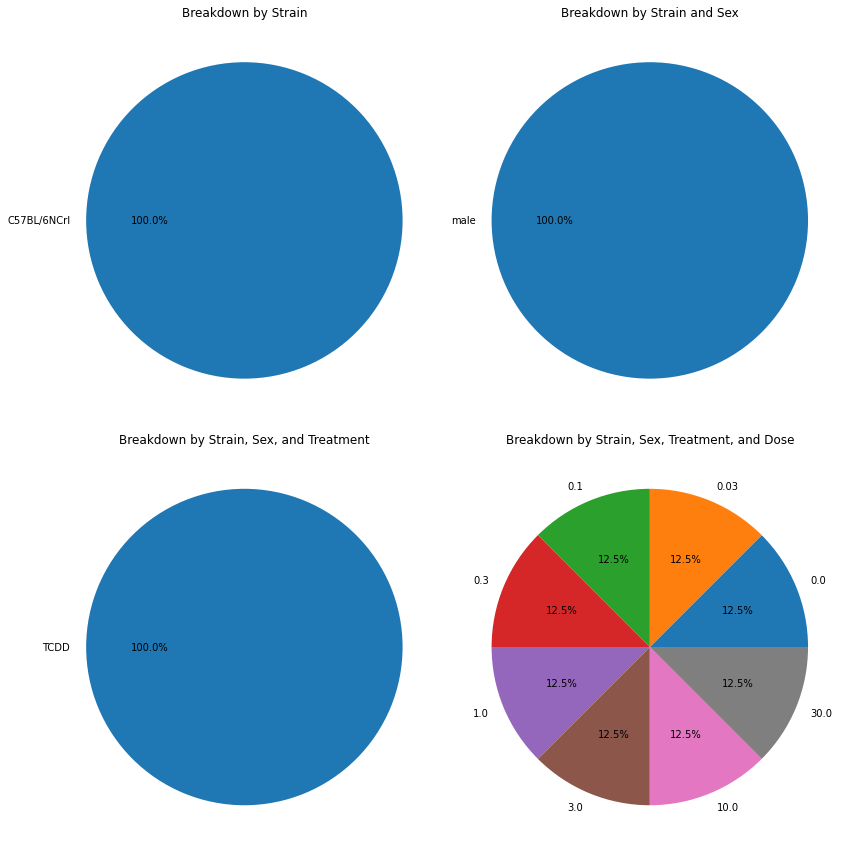

In [168]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Breakdown 1: Strain
strain_counts = subject_df['strain'].value_counts()
axes[0, 0].pie(strain_counts, labels=strain_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Breakdown by Strain')

# Breakdown 2: Strain + Sex
strain_sex_counts = subject_df.groupby(['strain', 'sex']).size().unstack()
axes[0, 1].pie(strain_sex_counts.values.flatten(), labels=strain_sex_counts.columns, autopct='%1.1f%%')
axes[0, 1].set_title('Breakdown by Strain and Sex')

# Breakdown 3: Strain + Sex + Treatment
strain_sex_treatment_counts = subject_df.groupby(['strain', 'sex', 'test_article_name']).size().unstack()
axes[1, 0].pie(strain_sex_treatment_counts.values.flatten(), labels=strain_sex_treatment_counts.columns, autopct='%1.1f%%')
axes[1, 0].set_title('Breakdown by Strain, Sex, and Treatment')

# Breakdown 4: Strain + Sex + Treatment + Dose
strain_sex_treatment_dose_counts = subject_df.groupby(['strain', 'sex', 'test_article_name', 'dose_amount']).size().unstack()
axes[1, 1].pie(strain_sex_treatment_dose_counts.values.flatten(), labels=strain_sex_treatment_dose_counts.columns, autopct='%1.1f%%')
axes[1, 1].set_title('Breakdown by Strain, Sex, Treatment, and Dose')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

<h2 align="center">Sample details</h2>

In [169]:
# Filter based on the previous query
subjects_to_match = subject_df['submitter_id_x'].unique()

# SAMPLE NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='sample', fileformat='tsv')
sample_df = process_node_data('sample', node_data, 'subjects.submitter_id')
sample_df = sample_df[sample_df['subjects.submitter_id'].isin(subjects_to_match)]

# ALIQUOT NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='aliquot', fileformat='tsv')
aliquot_df = process_node_data('aliquot', node_data, 'samples.submitter_id')
drop_columns = [col for col in aliquot_df.columns if pd.Series(col).str.contains(pattern).any()]
aliquot_df = aliquot_df.drop(drop_columns, axis=1)
aliquot_df = aliquot_df.reset_index(drop=True)
sample_df = pd.merge(sample_df, aliquot_df, left_on='submitter_id', right_on='samples.submitter_id')

# MASS_SPEC_ASSAY NODE
# Uses a different code to handle exceptions in the characters for long-form text
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='mass_spec_assay', fileformat='json')
node_data = remove_newlines(node_data)
ms_assay_df = pd.json_normalize(node_data['data'])
ms_assay_df = ms_assay_df.explode('aliquots')
ms_assay_df['aliquots.id'] = ms_assay_df['aliquots'].apply(lambda x: x['node_id'])
ms_assay_df['aliquots.submitter_id'] = ms_assay_df['aliquots'].apply(lambda x: x['submitter_id'])
ms_assay_df = ms_assay_df.drop('aliquots', axis=1)
drop_columns = [col for col in ms_assay_df.columns if pd.Series(col).str.contains(pattern).any()]
ms_assay_df = ms_assay_df.drop(drop_columns, axis=1)
ms_assay_df = ms_assay_df.drop_duplicates()
ms_assay_df = ms_assay_df.reset_index(drop=True)
sample_df = pd.merge(sample_df, ms_assay_df, left_on='submitter_id_y', right_on='aliquots.submitter_id')

# MS_RAW_DATA NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='ms_raw_data', fileformat='tsv')
ms_raw_data_df = process_node_data('ms_raw_data', node_data, 'mass_spec_assays.submitter_id')
drop_columns = [col for col in ms_raw_data_df.columns if pd.Series(col).str.contains(pattern).any()]
ms_raw_data_df = ms_raw_data_df.drop(drop_columns, axis=1)
ms_raw_data_df = ms_raw_data_df.drop_duplicates()
ms_raw_data_df = ms_raw_data_df.reset_index(drop=True)
sample_df = pd.merge(sample_df, ms_raw_data_df, left_on='submitter_id', right_on='mass_spec_assays.submitter_id')

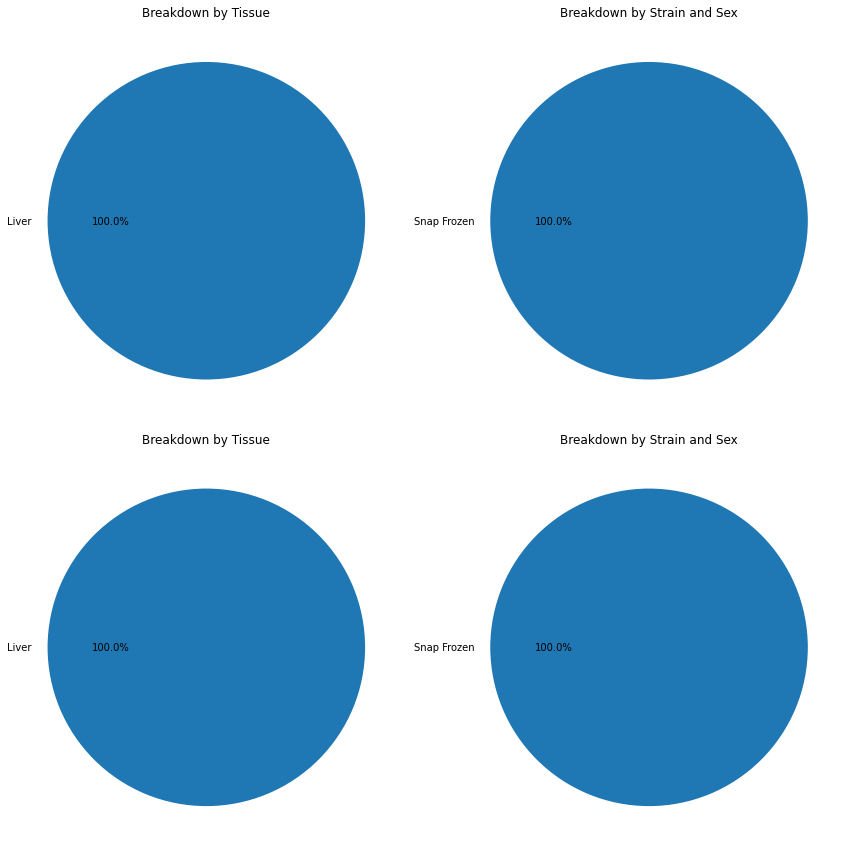

In [170]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Breakdown 1: Strain
strain_counts = sample_df['biospecimen_anatomic_site'].value_counts()
axes[0, 0].pie(strain_counts, labels=strain_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Breakdown by Tissue')

# Breakdown 2: Strain + Sex
strain_sex_counts = sample_df.groupby(['biospecimen_anatomic_site', 'preservation_method']).size().unstack()
axes[0, 1].pie(strain_sex_counts.values.flatten(), labels=strain_sex_counts.columns, autopct='%1.1f%%')
axes[0, 1].set_title('Breakdown by Strain and Sex')


# Breakdown 1: Strain
strain_counts = sample_df['biospecimen_anatomic_site'].value_counts()
axes[1, 0].pie(strain_counts, labels=strain_counts.index, autopct='%1.1f%%')
axes[1, 0].set_title('Breakdown by Tissue')

# Breakdown 2: Strain + Sex
strain_sex_counts = sample_df.groupby(['biospecimen_anatomic_site', 'preservation_method']).size().unstack()
axes[1, 1].pie(strain_sex_counts.values.flatten(), labels=strain_sex_counts.columns, autopct='%1.1f%%')
axes[1, 1].set_title('Breakdown by Strain and Sex')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

<h2 align="center">Mass spec data details</h2>

In [171]:
asssays_to_match = sample_df['mass_spec_assays.submitter_id'].unique()

node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='ms_raw_data', fileformat='tsv')
ms_raw_data_df = process_node_data('ms_raw_data', node_data, 'mass_spec_assays.submitter_id') 
ms_raw_data_df = ms_raw_data_df[ms_raw_data_df['mass_spec_assays.submitter_id'].isin(asssays_to_match)]

node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='ms_analysis', fileformat='tsv')
ms_analysis_df = process_node_data('ms_analysed_data', node_data, 'ms_raw_datas.submitter_id') 
ms_df = pd.merge(ms_raw_data_df, ms_analysis_df, left_on='submitter_id', right_on='ms_raw_datas.submitter_id')

node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='ms_analysed_data', fileformat='tsv')
ms_analysed_data_df = process_node_data('ms_analysed_data', node_data, 'submitter_id') 
ms_df = pd.merge(ms_df, ms_analysed_data_df, left_on='submitter_id_y', right_on='ms_analyses.submitter_id')

<h1 align="center">Build the mwTab File</h1> 

### Top-level "keys" in __mwTabFile__

- 'METABOLOMICS WORKBENCH' 
- 'PROJECT'
- 'STUDY'
- 'SUBJECT'
- 'SUBJECT_SAMPLE_FACTORS'
- 'COLLECTION'
- 'TREATMENT'
- 'SAMPLEPREP'
- 'CHROMATOGRAPHY'
- 'ANALYSIS'
- 'MS'
- 'MS_METABOLITE_DATA'

## Create an empty mwTabFile object
Look into another way to make an empty file or for a mechanism to ensure that we start with a completely blank object.

In [172]:
mwfiles_generator = mwtab.read_files("35")
mwfile = next(mwfiles_generator)

In [173]:
for key in mwfile.keys():
    mwfile[key] = OrderedDict()

with open("empty_mwtab.txt", "w") as outfile:
    mwfile.write(outfile, file_format="mwtab")

In [174]:
keys = ['Units', 'Data', 'Metabolites']
initial_values = [None] * len(keys)

my_ordered_dict = OrderedDict(zip(keys, initial_values))

mwfile["MS_METABOLITE_DATA"] = my_ordered_dict

mwfile["MS_METABOLITE_DATA"].keys()

odict_keys(['Units', 'Data', 'Metabolites'])

## Build METABOLOMICS WORKBENCH block

In [175]:
# For some reason the IDs don't change. Check this.
json_data = {
    "VERSION": "1",
    "CREATED_ON": str(formatted_date)
}

ordered_dict = OrderedDict(json_data)

mwfile['METABOLOMICS WORKBENCH'] = ordered_dict

## Build PROJECT block

In [176]:
json_data = {
    "PROJECT_TITLE": get_unique_values(study_df, 'study_title'),
    "PROJECT_TYPE": get_unique_values(sample_df, 'data_category'), 
    "PROJECT_SUMMARY": get_unique_values(study_df, 'study_description'),
    "INSTITUTE": get_unique_values(study_df, 'contact_institution'),
    "LAST_NAME": get_unique_values(study_df, 'last_name'),
    "FIRST_NAME": get_unique_values(study_df, 'first_name'),
    "DEPARTMENT": get_unique_values(study_df, 'contact_department'),
    #"LABORATORY":"dbzach.fst.msu.edu",
    "ADDRESS":get_unique_values(study_df, 'location'),
    "EMAIL":get_unique_values(study_df, 'contact_email'),
    "PHONE":get_unique_values(study_df, 'contact_telephone'),
    "FUNDING_SOURCE": get_unique_values(study_df, 'support_source') + ' ' + get_unique_values(study_df, 'support_id')
}

mwfile['PROJECT'] = OrderedDict(json_data)

## Build STUDY block
Most datasets just use the same data as Project. Here we may be able to do better.

In [177]:
# Subset the subjects for only those that have a matching MS assay
aliquot_list = ms_assay_df['aliquots.submitter_id']
subject_list = sample_df[sample_df['aliquots.submitter_id'].isin(aliquot_list)]['subjects.submitter_id']
subject_subset = subject_df[subject_df['submitter_id_x'].isin(subject_list)]

columns_to_include = ['submitter_id_x','sex','test_article_name', 'dose_amount']

# Create a new DataFrame with only the specified columns
selected_columns = columns_to_include
subset_df = subject_subset[selected_columns].drop_duplicates()
subset_df = subset_df.reset_index(drop=True)

# Count the frequency of two values in the column
value_counts = subset_df['sex'].value_counts()

# Get the frequency of specific values
female_count = value_counts.get('female', 0)
male_count = value_counts.get('male', 0)
groups = subset_df['dose_amount'].nunique()

In [178]:
json_data = { 
    "STUDY_TITLE": get_unique_values(study_df, 'study_title'),
    "STUDY_TYPE": get_unique_values(sample_df, 'data_type'),
    "STUDY_SUMMARY": get_unique_values(study_df, 'study_description'),
    "INSTITUTE":get_unique_values(study_df, 'contact_institution'),
    "DEPARTMENT":get_unique_values(study_df, 'contact_department'),
    "LAST_NAME": get_unique_values(study_df, 'last_name'),
    "FIRST_NAME": get_unique_values(study_df, 'first_name'),
    "ADDRESS":get_unique_values(study_df, 'location'),
    "EMAIL":get_unique_values(study_df, 'contact_email'),
    "PHONE":get_unique_values(study_df, 'contact_telephone'),
    "NUM_GROUPS":int(groups),
    "TOTAL_SUBJECTS":int(len(get_unique_values(subset_df, 'submitter_id_x').split(','))),
    "NUM_MALES":int(male_count),
    "NUM_FEMALES":int(female_count)
}


# original dict
ordered_dict = OrderedDict(json_data)

# key transformation
#renamed_dict = OrderedDict((key_mappings.get(key, key), value) for key, value in ordered_dict.items())

mwfile['STUDY'] = ordered_dict

## Build SUBJECT block
Each blocks are an `OrderedDict` class

In [179]:
# replace this with a gen3 query
json_data = {
    "SUBJECT_TYPE": "Mammal",  #*dropdown
    "SUBJECT_SPECIES": get_unique_values(study_df, 'organism'),
    "TAXONOMY_ID":"10090", 
    "SPECIES_GROUP": "Mammal",
    "AGE_OR_AGE_RANGE": get_unique_values(subject_df, 'age'),
    "GENDER": get_unique_values(subject_df, 'sex'),
    "ANIMAL_ANIMAL_SUPPLIER": get_unique_values(subject_df, 'strain_source'),
    "ANIMAL_HOUSING": 'cage_type: ' + 
                        get_unique_values(subject_df, 'cage_type') + 
                        '; bedding_type: ' + 
                        get_unique_values(subject_df, 'bedding_type'),
    "ANIMAL_LIGHT_CYCLE":get_unique_values(subject_df, 'vivarium_light_cycle'),
    "ANIMAL_FEED":get_unique_values(subject_df, 'feed_name'),
    "ANIMAL_WATER":get_unique_values(subject_df, 'water_type')
}

# original dict
ordered_dict = OrderedDict(json_data)

mwfile['SUBJECT'] = ordered_dict

## Build SUBJECT_SAMPLE_FACTORS block
Each blocks are an `OrderedDict` class

In [180]:
subject_subset = subject_df[['submitter_id_x', 'dose_amount', 'dose_amount_unit', 'test_article_name']].drop_duplicates()

subject_subset['dose_group'] = subject_subset['dose_amount'].astype(str) + ' ' + subject_subset['dose_amount_unit'].astype(str)

sample_subset = sample_df[['subjects.submitter_id', 'submitter_id_x', 'file_name']].drop_duplicates()

json_SUBJECT_SAMPLE_FACTORS = []

for index, row in sample_subset.iterrows():
    subject_sample = {}
    subject_sample.update({'Subject ID': row['subjects.submitter_id'].split(":")[-1].strip()})
    subject_sample.update({'Sample ID': row.submitter_id_x[1].split(":")[-1].strip()})
    factors = subject_subset[subject_subset['submitter_id_x'] == row['subjects.submitter_id']]
    factor_vals = {}
    for _, row_factors in factors.iterrows():
        for f in row_factors.index:
            if f not in ['submitter_id_x', 'dose_amount', 'dose_amount_unit']:
                factor_vals.update({f: row_factors[f]})
    subject_sample.update({'Factors':factor_vals})
    subject_sample.update({'Additional sample data': {"RAW_FILE_NAME": row['file_name'].replace('.raw', '.mzML')}})
    if subject_sample:
        json_SUBJECT_SAMPLE_FACTORS.append(OrderedDict(subject_sample)) 

mwfile['SUBJECT_SAMPLE_FACTORS'] = json_SUBJECT_SAMPLE_FACTORS

## Build COLLECTION block
Each blocks are an `OrderedDict` class

In [181]:
json_data = {
    #COLLECTION_SUMMARY": get_unique_values(sample_df, 'method_of_sample_procurement'),
    "COLLECTION_SUMMARY": 'Samples were collected by necropsy and flash frozen in liquid nitrogren',
    #"COLLECTION_PROTOCOL_ID": ,
    #"COLLECTION_PROTOCOL_FILENAME": ,
    #"COLLECTION_PROTOCOL_COMMENTS": ,
    "SAMPLE_TYPE": get_unique_values(sample_df, 'biospecimen_anatomic_site'), 
    #"COLLECTION_METHOD": ,
    #"COLLECTION_LOCATION": ,
    #"COLLECTION_DURATION": ,
    #"COLLECTION_FREQUENCY": ,
    "STORAGE_CONDITIONS":get_unique_values(sample_df, 'preservation_method'),
    #"STORAGE_VIALS": "Tube type",
    #"COLLECTION_TUBE_TEMP":"Tube storage",
}

# original dict
ordered_dict = OrderedDict(json_data)

mwfile['COLLECTION'] = ordered_dict

## Build TREATMENT block
Each blocks are an `OrderedDict` class

In [182]:
# replace this with a gen3 query
json_data = {
    #"TREATMENT_SUMMARY": get_unique_values(subject_df, 'treatment_protocol'),
    "TREATMENT_SUMMARY": "Mice were orally gavaged with 0.1 mL of the test article in vehicle to achieve the expected dosage every 4 days for 28 days for a total of 7 administrations.",
    #"TREATMENT_PROTOCOL_ID":,
    #"TREATMENT_PROTOCOL_FILENAME":,
    #"TREATMENT_PROTOCOL_COMMENTS":,
    #"TREATMENT":,
    "TREATMENT_COMPOUND": get_unique_values(subject_df, 'test_article_dtxsid') + ': ' + get_unique_values(subject_df, 'test_article_name'),
    "TREATMENT_ROUTE":get_unique_values(subject_df, 'route'),
    "TREATMENT_DOSE":str(sorted(get_unique_values(subject_df, 'dose_amount').split(','))),
    "TREATMENT_DOSEVOLUME": get_unique_values(subject_df, 'administration_volume_ml') + ' ' + 'mL',
    "TREATMENT_VEHICLE":get_unique_values(subject_df, 'vehicle_dtxsid') + ': ' + get_unique_values(subject_df, 'vehicle_name'),
    #"ANIMAL_VET_TREATMENTS":,
    #"ANIMAL_ANESTHESIA":,
    #"ANIMAL_ACCLIMATION_DURATION":,
    "ANIMAL_FASTING":get_unique_values(subject_df, 'feed_paradigm'),
    "ANIMAL_ENDP_EUTHANASIA":get_unique_values(subject_df, 'euthanasia_method'),
    "ANIMAL_ENDP_TISSUE_COLL_LIST":get_unique_values(sample_df, 'biospecimen_anatomic_site')
    #"ANIMAL_ENDP_TISSUE_PROC_METHOD":get_unique_values(sample_df, 'method_of_sample_procurement')
}

# original dict
ordered_dict = OrderedDict(json_data)

mwfile['TREATMENT'] = ordered_dict

## Build SAMPLEPREP block
Each blocks are an `OrderedDict` class

In [183]:
# replace this with a gen3 query

tmp_string = ("Flash frozen liver samples (about 25 mg) were extracted using HPLC-grade methanol and water (5:3 ratio)"
    "containing 13C-,15N-labeled amino acid (Sigma; 767964) internal standards. HPLC-grade chloroform (methanol:water:chloroform "    
    "ratio 5:3:5) was added, vortexed, shaken for 15 min at 4 Celsius, and centrifuged at maximum speed (3000 x g) to achieve "
    "phase separation. The methanol:water phase containing the polar metabolites was transferred, dried under nitrogen gas at "
    "room temperature. Untargeted extractions were reconstituted with 400 ul of 10 mM tributylamine and 15 mM acetic acid in "
    "97:3 water:methanol for analysis.")

json_data = {
    #"SAMPLEPREP_SUMMARY": get_unique_values(sample_df, 'analyte_protocol'),
    "SAMPLEPREP_SUMMARY": tmp_string,
    "PROCESSING_STORAGE_CONDITIONS": get_unique_values(sample_df, 'extract_preservation_method'),
    #"SAMPLEPREP_PROTOCOL_ID":"protid",
    #"SAMPLEPREP_PROTOCOL_FILENAME":"protfile",
    #"SAMPLEPREP_PROTOCOL_COMMENTS":"procomm",
    #"PROCESSING_METHOD":"procmethod",
    #"PROCESSING_STORAGE_CONDITIONS":"80",
    #"EXTRACTION_METHOD":"extmethod",
    #"EXTRACT_CONCENTRATION_DILUTION":"dilution",
    #"EXTRACT_ENRICHMENT":"enrch",
    #"EXTRACT_CLEANUP":"clean",
    #"EXTRACT_STORAGE":"-80",
    #"SAMPLE_RESUSPENSION":"resyus",
    "SAMPLE_DERIVATIZATION":get_unique_values(sample_df, 'derivitization'),
    "SAMPLE_SPIKING":get_unique_values(sample_df, 'calibration_standard')
    #"SUBCELLULAR_LOCATION":"subcell loc",
}

json_data = {k: v for k, v in json_data.items() if v != 'nan'}

# original dict
ordered_dict = OrderedDict(json_data)

mwfile['SAMPLEPREP'] = ordered_dict

## Build CHROMATOGRAPHY block
Each blocks are an `OrderedDict` class

In [184]:
# replace this with a gen3 query
json_data = {
    "CHROMATOGRAPHY_SUMMARY": get_unique_values(ms_assay_df, 'chromatography_protocol'),
    "CHROMATOGRAPHY_TYPE": get_unique_values(ms_assay_df, 'chromatography_type'),
    "INSTRUMENT_NAME": get_unique_values(ms_assay_df, 'chromatography_instrument'),
    "COLUMN_NAME": get_unique_values(ms_assay_df, 'chromatography_column'),
    "SOLVENT_A": get_unique_values(ms_assay_df, 'solventA'),
    "SOLVENT_B": get_unique_values(ms_assay_df, 'solventB'),
    "SOLVENT_C": get_unique_values(ms_assay_df, 'solventC'),
    "FLOW_GRADIENT": get_unique_values(ms_assay_df, 'elution_program'),
    "FLOW_RATE":get_unique_values(ms_assay_df, 'flow_rate'),
    #"COLUMN_TEMPERATURE":"376",
    "METHODS_FILENAME":get_unique_values(ms_assay_df, 'chromatography_method_filename')
    #"METHODS_ID":"id",
    #"COLUMN_PRESSURE":"colpress",
    #"INJECTION_TEMPERATURE":"injtemp"
}

# original dict
ordered_dict = OrderedDict(json_data)

mwfile['CHROMATOGRAPHY'] = ordered_dict

## Build ANALYSIS block
Each blocks are an `OrderedDict` class

In [185]:
# replace this with a gen3 query
json_data = {
    "ANALYSIS_TYPE": "MS"
}

# original dict
ordered_dict = OrderedDict(json_data)

mwfile['ANALYSIS'] = ordered_dict

## Build MS block
Each blocks are an `OrderedDict` class

In [186]:
# replace this with a gen3 query
json_data = {
    "INSTRUMENT_NAME": "Waters Xevo-TQ-S", 
    "INSTRUMENT_TYPE": "Triple quadrupole",
    "MS_TYPE": get_unique_values(ms_assay_df, 'ms_type'),
    "ION_MODE": get_unique_values(ms_assay_df, 'ion_mode'),
    "MS_COMMENTS": "protocol"
}

# original dict
ordered_dict = OrderedDict(json_data)

mwfile['MS'] = ordered_dict

## Build MS_METABOLITE_DATA block

#### The following block use hard-coded file paths until ToxDataCommons implements S3 buckets.

In [187]:
mwfile["MS_METABOLITE_DATA"]["Units"] = 'normalized peak area'

In [188]:
file_path = './Karina_realData/CEC_mn_normalized_peak_area.txt'

# Read the tab-delimited file
with open(file_path, 'r', newline='') as file:
    reader = csv.reader(file, delimiter='\t')
    # Extract the keys from the first row
    keys = next(reader)

    # Create a list of OrderedDict objects
    metabolite_data = [
        OrderedDict(zip(keys, row)) for row in reader
    ]

mwfile['MS_METABOLITE_DATA']['Data'] = metabolite_data

In [193]:
ms_analysed_data_id = ["Prj171:CEC_normalized_peak_area.txt"]
exclude_list = [get_unique_values(ms_assay_df, 'calibration_standard')]

# METABOLITE_ID NODE
node_data = sub.export_node(program='MyFirstProgram', project='MyFirstProject', node_type='metabolite_id', fileformat='tsv')
metabolite_df = process_node_data('metabolite_id', node_data, 'ms_analysed_datas.submitter_id')
metabolite_df = metabolite_df[(metabolite_df['ms_analysed_datas.submitter_id'].isin(ms_analysed_data_id)) &
                            (~metabolite_df['metabolite_name'].isin(exclude_list))]



In [194]:
json_data = []

for _, row in metabolite_df.iterrows():
    js = {
        "Metabolite": row['metabolite_name'],
        "DTXSID": row['dtxsid'],
        "InChI": 'InChI=' + row['inchikey'],
        "Average Mass": str(row['mass']),
        "elution_time": str(row['elution_time'])
    }
    json_data.append(OrderedDict(js))

mwfile["MS_METABOLITE_DATA"]["Metabolites"] = json_data

[OrderedDict([('Metabolite', 'S-(2-carboxyethyl)-L-cysteine'), ('DTXSID', 'DTXSID40193329'), ('InChI', 'InChI=1S/C6H11NO4S/c7-4(6(10)11)3-12-2-1-5(8)9/h4H,1-3,7H2,(H,8,9)(H,10,11)/t4-/m0/s1'), ('Average Mass', '193.22'), ('elution_time', '2.6')])]


## Export the file

In [195]:
from mwtab.converter import Converter

with open("temp_mwtab.json", "w") as outfile:
    mwfile.write(outfile, file_format="json")

converter = Converter(from_path="temp_mwtab.json", to_path="temp_mwtab.txt",
                      from_format="json", to_format="mwtab")
converter.convert()

# Validate & upload your mwTab file

## Validation

mwTab files can be validated using the python mwTab command line or the [online validator](https://www.metabolomicsworkbench.org/data/mwtab_validate_form.php). It is recommended to use both forms of validation as they report different things. 

In [4]:
! mwtab validate ../../../DH_RealData/SRC_TZES004911_Prj171/CEC_Prj171_mwTab.txt --verbose

Processed file: C:\Users\15177\OneDrive - Michigan State University\Documents\Projects\FAIRTox\DH_RealData\SRC_TZES004911_Prj171\CEC_Prj171_mwTab.txt
Validation Log
2023-06-16 16:41:53.617148
mwtab Python Library Version: 1.2.5
Source:        ../../../DH_RealData/SRC_TZES004911_Prj171/CEC_Prj171_mwTab.txt
Study ID:      None
Analysis ID:   None
File format:   
Status: Passing


## Upload to the metabolomic workbench ftp server

- Compress your folder containing mwTab and associated files (.zip or .7z)
- Log into [metabolomic workbench](metabolomicsworkbench.org)
- Find the NMDR FTP information. It will have the following:
    __Server name__:
    __User name__:
    __Password__:
- Connect to the FTP server using a tool such as _FileZilla_ or _WinSCP_ and upload the data